# Import the Required Libraries

In [13]:
import numpy as np
import pandas as pd
import random as rd
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
%matplotlib inline
plt.style.use('ggplot')
import warnings
warnings.filterwarnings("ignore")

In [6]:
from statsmodels.tsa.arima_model import ARIMA  # Autoregressive Integrated Moving Average ARIMA(p,d,q) Model
from statsmodels.tsa.statespace.sarimax import SARIMAX  # Seasonal AutoRegressive Integrated Moving Average with eXogenous regressors model
from pandas.plotting import autocorrelation_plot  # Autocorrelation plot for time series
from statsmodels.tsa.stattools import adfuller, acf, pacf,arma_order_select_ic  # 
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

# Load the DataSets

In [7]:
sales = pd.read_csv("D:/DataSets/competitive-data-science-predict-future-sales/sales_train.csv")
item_cat = pd.read_csv("D:/DataSets/competitive-data-science-predict-future-sales/item_categories.csv")
item = pd.read_csv("D:/DataSets/competitive-data-science-predict-future-sales/items.csv")
sub = pd.read_csv("D:/DataSets/competitive-data-science-predict-future-sales/sample_submission.csv")
shops = pd.read_csv("D:/DataSets/competitive-data-science-predict-future-sales/shops.csv")
test = pd.read_csv("D:/DataSets/competitive-data-science-predict-future-sales/test.csv")

In [8]:
# Format the data column in sales correctly
sales.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [9]:
sales.date=sales.date.apply(lambda x:datetime.datetime.strptime(x, '%d.%m.%Y'))

In [10]:
sales.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-01-02,0,59,22154,999.00,1.0
1,2013-01-03,0,25,2552,899.00,1.0
2,2013-01-05,0,25,2552,899.00,-1.0
3,2013-01-06,0,25,2554,1709.05,1.0
4,2013-01-15,0,25,2555,1099.00,1.0


In [12]:
# Aggregate to monthly level the required metrics

monthly_sales = sales.groupby(["date_block_num","shop_id","item_id"])["date","item_price","item_cnt_day"].agg({"date":["min",'max'],"item_price":"mean","item_cnt_day":"sum"})
monthly_sales.head(20)

date            item_price item_cnt_day
                                      min        max       mean          sum
date_block_num shop_id item_id                                              
0              0       32      2013-01-03 2013-01-31      221.0          6.0
                       33      2013-01-03 2013-01-28      347.0          3.0
                       35      2013-01-31 2013-01-31      247.0          1.0
                       43      2013-01-31 2013-01-31      221.0          1.0
                       51      2013-01-13 2013-01-31      128.5          2.0
                       61      2013-01-10 2013-01-10      195.0          1.0
                       75      2013-01-17 2013-01-17       76.0          1.0
                       88      2013-01-16 2013-01-16       76.0          1.0
                       95      2013-01-06 2013-01-06      193.0          1.0
                       96      2013-01-10 2013-01-10       70.0          1.0
                       98      2013-01-04 2013-01-31      268.0         25.0
                       111     2013-01-17 2013-01-17       89.0          1.0
                       149     2013-01-11 2013-01-28       99.0          3.0
                       151     2013-01-16 2013-01-16       75.0          1.0
                       153     2013-01-09 2013-01-09      258.0          1.0
                       198     2013-01-10 2013-01-10      112.0          1.0
                       210     2013-01-05 2013-01-25      118.0          2.0
                       282     2013-01-04 2013-01-04      109.0          1.0
                       306     2013-01-22 2013-01-22       59.0          1.0
                       351     2013-01-21 2013-01-21       89.0          1.0

In [14]:
# number of items per cat

x = item.groupby(['item_category_id']).count()
x = x.sort_values(by='item_id',ascending=False)
x = x.iloc[0:10].reset_index()
x

,item_category_id,item_name,item_id
0,40,5035,5035
1,55,2365,2365
2,37,1780,1780
3,31,1125,1125
4,58,790,790
5,30,756,756
6,72,666,666
7,19,628,628
8,61,598,598
9,23,501,501


In [22]:
fig = px.bar(x.item_category_id, x.item_id, color='item_category_id')
fig.show()

# Single Series

The objective requires us to predict sales for the next month at a store-item combination.

Sales over time of each store-item is a time-series in itself. Before we dive into all the combinations, first let's understand how to forecast for a single series.

I've chosen to predict for the total sales per month for the entire company.

First let's compute the total sales per month and plot that data.

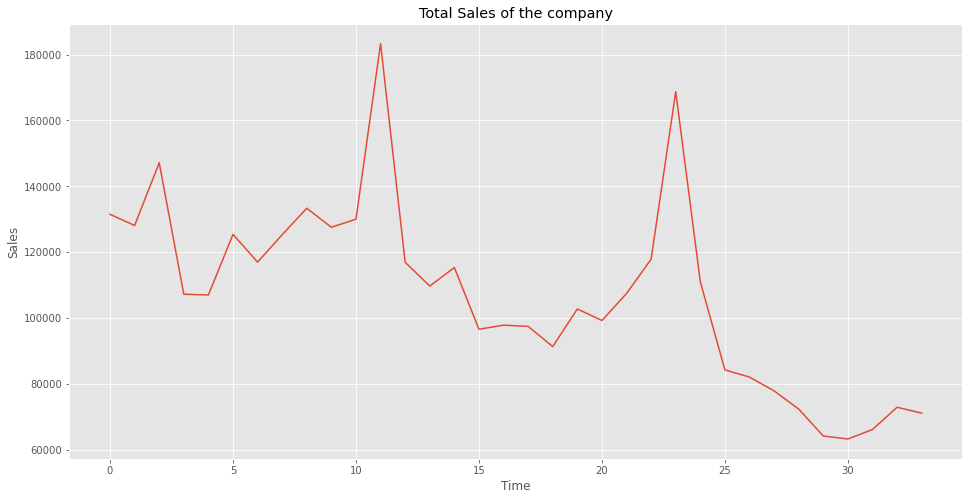

In [29]:
ts=sales.groupby(["date_block_num"])["item_cnt_day"].sum()
ts.astype('float')
plt.figure(figsize=(16,8))
plt.title('Total Sales of the company')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.plot(ts)

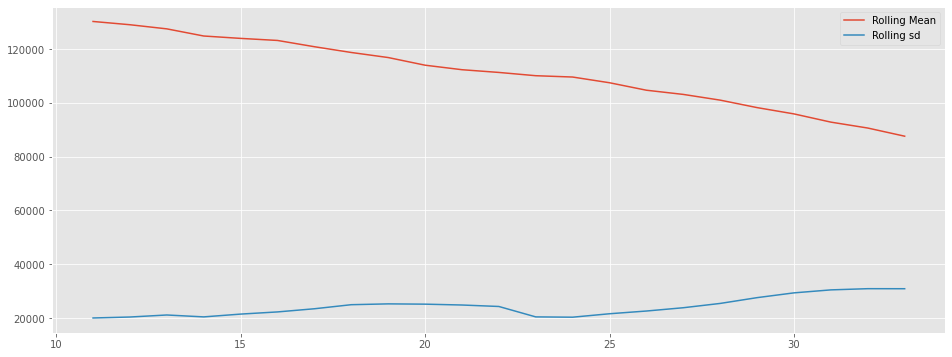

In [30]:
plt.figure(figsize=(16,6))
plt.plot(ts.rolling(window=12,center=False).mean(),label='Rolling Mean');
plt.plot(ts.rolling(window=12,center=False).std(),label='Rolling sd');
plt.legend();

Let's check that with a quick decomposition into Trend, seasonality and residuals.

<Figure size 1152x864 with 0 Axes>

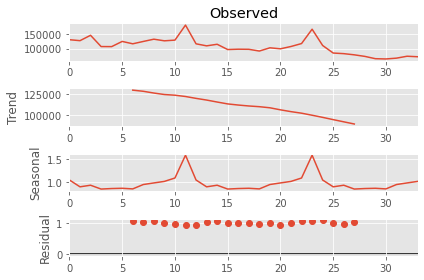

In [35]:
import statsmodels.api as sm
# multiplicative
res = sm.tsa.seasonal_decompose(ts.values,freq=12,model="multiplicative")
plt.figure(figsize=(16,12))
fig = res.plot()
fig.show()

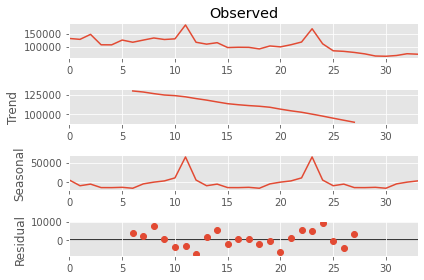

In [36]:
# Additive model
res = sm.tsa.seasonal_decompose(ts.values,freq=12,model="additive")
#plt.figure(figsize=(16,12))
fig = res.plot()
#fig.show()

In [37]:
# Stationarity tests
def test_stationarity(timeseries):
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

test_stationarity(ts)

Results of Dickey-Fuller Test:
Test Statistic                 -2.395704
p-value                         0.142953
#Lags Used                      0.000000
Number of Observations Used    33.000000
Critical Value (1%)            -3.646135
Critical Value (5%)            -2.954127
Critical Value (10%)           -2.615968
dtype: float64


In [38]:
# to remove trend
from pandas import Series as Series
# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)

# invert differenced forecast
def inverse_difference(last_ob, value):
    return value + last_ob

[]

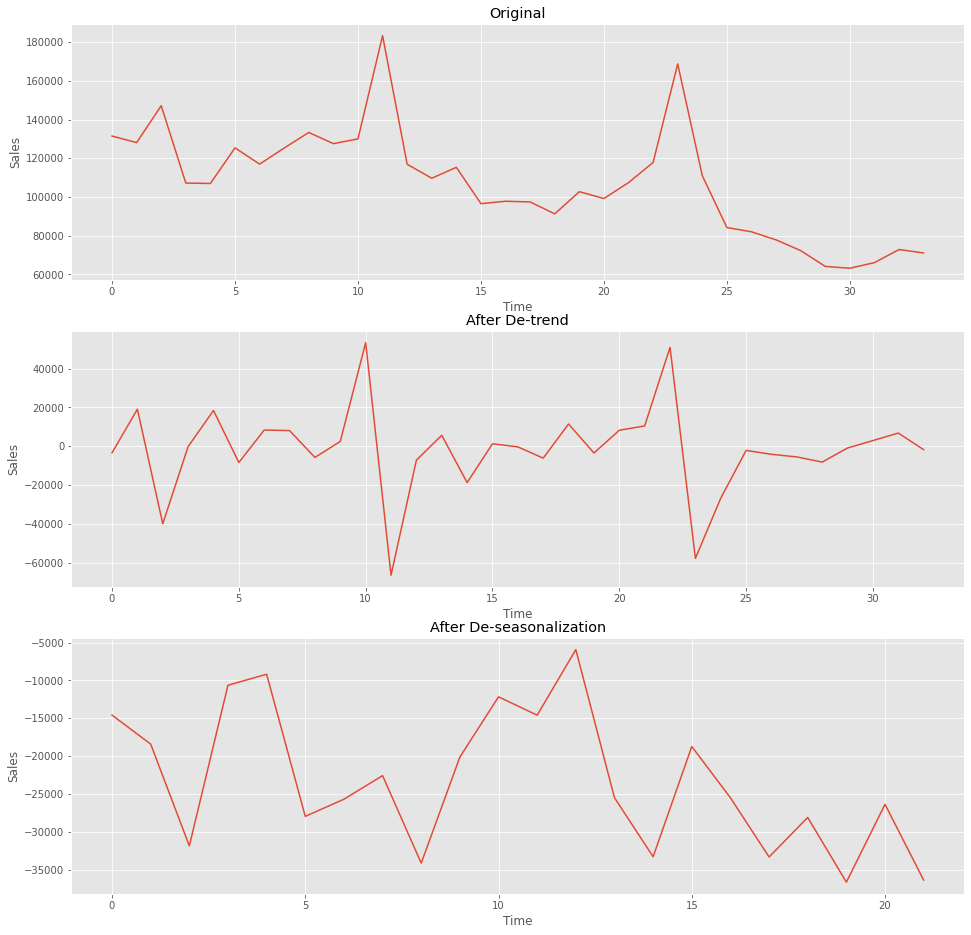

In [39]:
ts=sales.groupby(["date_block_num"])["item_cnt_day"].sum()
ts.astype('float')
plt.figure(figsize=(16,16))
plt.subplot(311)
plt.title('Original')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.plot(ts)
plt.subplot(312)
plt.title('After De-trend')
plt.xlabel('Time')
plt.ylabel('Sales')
new_ts=difference(ts)
plt.plot(new_ts)
plt.plot()

plt.subplot(313)
plt.title('After De-seasonalization')
plt.xlabel('Time')
plt.ylabel('Sales')
new_ts=difference(ts,12)       # assuming the seasonality is 12 months long
plt.plot(new_ts)
plt.plot()

In [40]:
# now testing the stationarity again after de-seasonality
test_stationarity(new_ts)

Results of Dickey-Fuller Test:
Test Statistic                 -3.270101
p-value                         0.016269
#Lags Used                      0.000000
Number of Observations Used    21.000000
Critical Value (1%)            -3.788386
Critical Value (5%)            -3.013098
Critical Value (10%)           -2.646397
dtype: float64


Now after the transformations, our p-value for the DF test is well within 5 %. Hence we can assume Stationarity of the series

# AR, MA and ARMA models

In [41]:
def tsplot(y, lags=None, figsize=(10, 8), style='bmh',title=''):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        #mpl.rcParams['font.family'] = 'Ubuntu Mono'
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title(title)
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return 

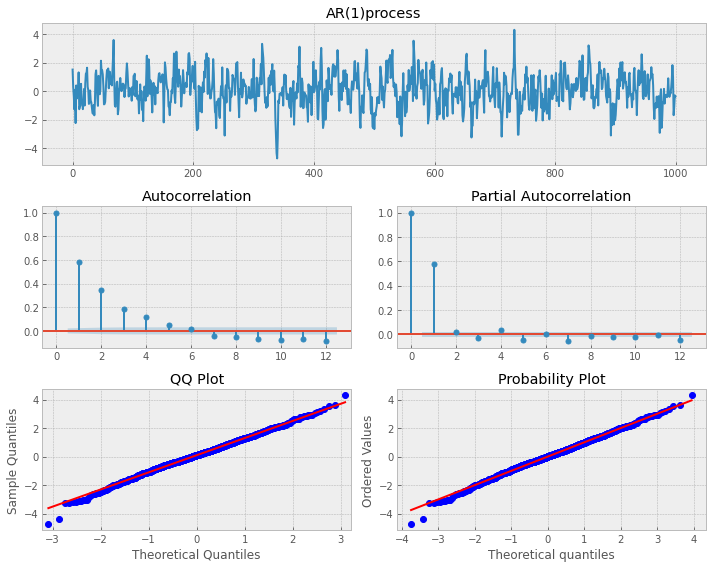

In [42]:
# Simulate an AR(1) process with alpha = 0.6
np.random.seed(1)
n_samples = int(1000)
a = 0.6
x = w = np.random.normal(size=n_samples)

for t in range(n_samples):
    x[t] = a*x[t-1] + w[t]
limit=12    
_ = tsplot(x, lags=limit,title="AR(1)process")

# AR(1) process -- has ACF tailing out and PACF cutting off at lag=1

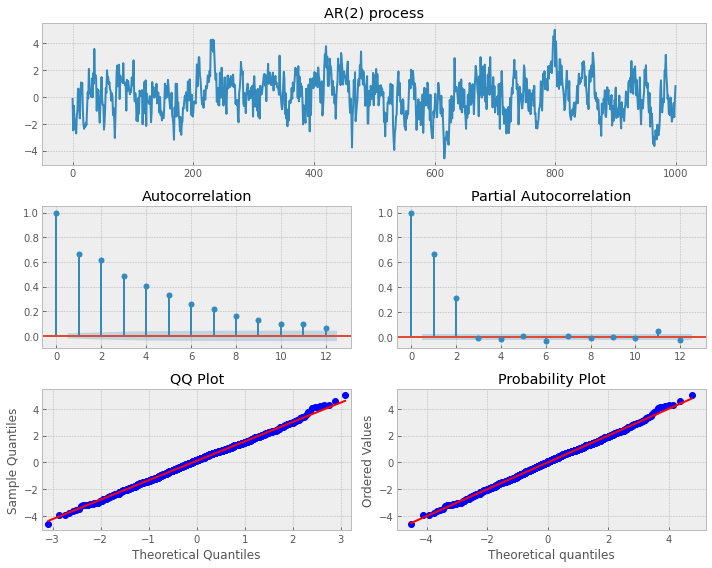

In [43]:
# Simulate an AR(2) process

n = int(1000)
alphas = np.array([.444, .333])
betas = np.array([0.])

# Python requires us to specify the zero-lag value which is 1
# Also note that the alphas for the AR model must be negated
# We also set the betas for the MA equal to 0 for an AR(p) model
# For more information see the examples at statsmodels.org
ar = np.r_[1, -alphas]
ma = np.r_[1, betas]

ar2 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n) 
_ = tsplot(ar2, lags=12,title="AR(2) process")

# AR(2) process -- has ACF tailing out and PACF cutting off at lag=2

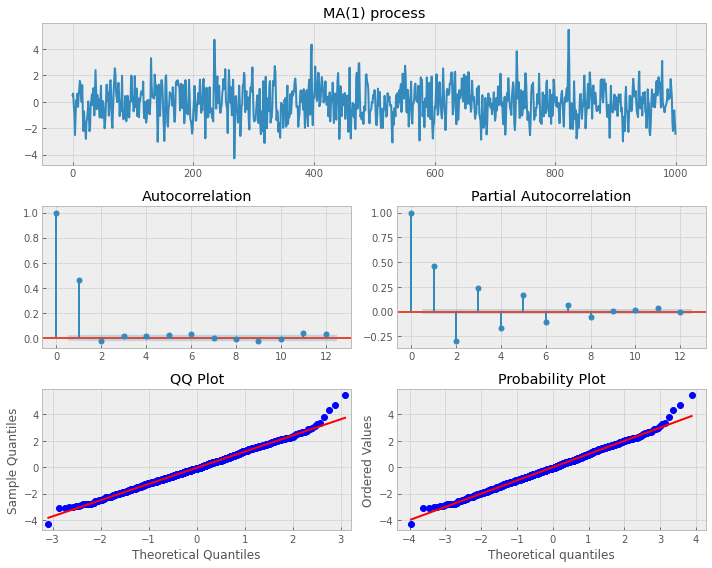

In [44]:
# Simulate an MA(1) process
n = int(1000)
# set the AR(p) alphas equal to 0
alphas = np.array([0.])
betas = np.array([0.8])
# add zero-lag and negate alphas
ar = np.r_[1, -alphas]
ma = np.r_[1, betas]
ma1 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n) 
limit=12
_ = tsplot(ma1, lags=limit,title="MA(1) process")

# MA(1) process -- has ACF cut off at lag=1

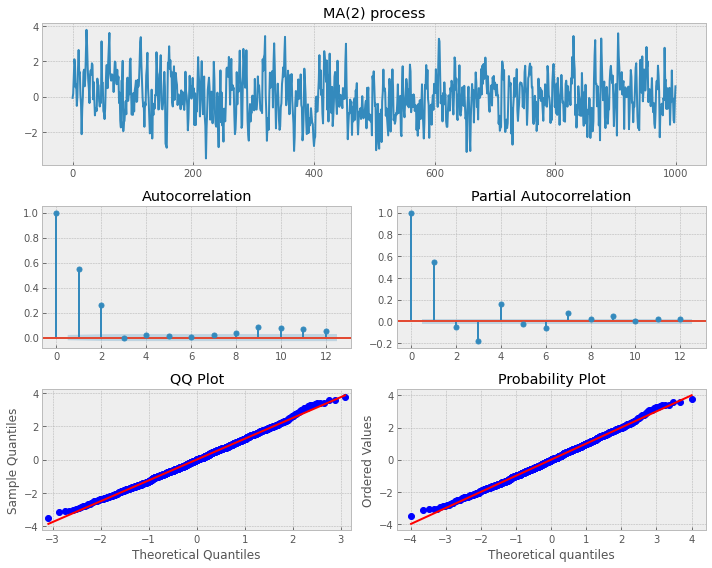

In [45]:
# Simulate MA(2) process with betas 0.6, 0.4
n = int(1000)
alphas = np.array([0.])
betas = np.array([0.6, 0.4])
ar = np.r_[1, -alphas]
ma = np.r_[1, betas]

ma3 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n)
_ = tsplot(ma3, lags=12,title="MA(2) process")

# MA(2) process -- has ACF cut off at lag=2

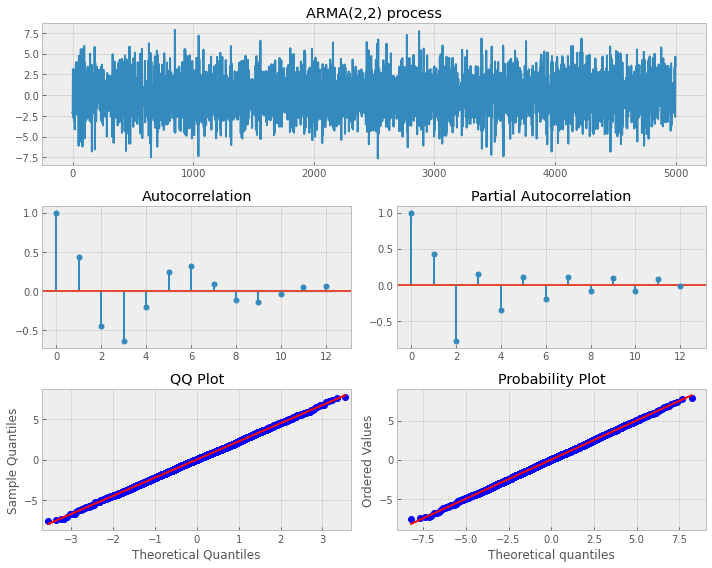

In [46]:
# Simulate an ARMA(2, 2) model with alphas=[0.5,-0.25] and betas=[0.5,-0.3]
max_lag = 12

n = int(5000) # lots of samples to help estimates
burn = int(n/10) # number of samples to discard before fit

alphas = np.array([0.8, -0.65])
betas = np.array([0.5, -0.7])
ar = np.r_[1, -alphas]
ma = np.r_[1, betas]

arma22 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n, burnin=burn)
_ = tsplot(arma22, lags=max_lag,title="ARMA(2,2) process")

# Let's use a systematic approach to finding the order of AR and MA processes.

In [47]:
# pick best order by aic 
# smallest aic value wins
best_aic = np.inf 
best_order = None
best_mdl = None

rng = range(5)
for i in rng:
    for j in rng:
        try:
            tmp_mdl = smt.ARMA(arma22, order=(i, j)).fit(method='mle', trend='nc')
            tmp_aic = tmp_mdl.aic
            if tmp_aic < best_aic:
                best_aic = tmp_aic
                best_order = (i, j)
                best_mdl = tmp_mdl
        except: continue


print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))

aic: 15326.68109 | order: (2, 2)


# Lets use it for the sales time-series

In [48]:
# pick best order by aic 
# smallest aic value wins
best_aic = np.inf 
best_order = None
best_mdl = None

rng = range(5)
for i in rng:
    for j in rng:
        try:
            tmp_mdl = smt.ARMA(new_ts.values, order=(i, j)).fit(method='mle', trend='nc')
            tmp_aic = tmp_mdl.aic
            if tmp_aic < best_aic:
                best_aic = tmp_aic
                best_order = (i, j)
                best_mdl = tmp_mdl
        except: continue


print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))

aic: 472.99703 | order: (1, 1)


In [49]:
# adding the dates to the Time-series as index
ts=sales.groupby(["date_block_num"])["item_cnt_day"].sum()
ts.index=pd.date_range(start = '2013-01-01',end='2015-10-01', freq = 'MS')
ts=ts.reset_index()
ts.head()

,index,item_cnt_day
0,2013-01-01,131479.0
1,2013-02-01,128090.0
2,2013-03-01,147142.0
3,2013-04-01,107190.0
4,2013-05-01,106970.0


# Prophet 

In [50]:
from fbprophet import Prophet
#prophet reqiures a pandas df at the below config 
# ( date column named as DS and the value column as Y)
ts.columns=['ds','y']
model = Prophet( yearly_seasonality=True) #instantiate Prophet with only yearly seasonality as our data is monthly 
model.fit(ts) #fit the model with your dataframe

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [51]:
# predict for five months in the furure and MS - month start is the frequency
future = model.make_future_dataframe(periods = 5, freq = 'MS')  
# now lets make the forecasts
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
34,2015-11-01,83193.957240,80157.850210,86253.821900
35,2015-12-01,125513.062950,122507.614806,128527.676856
36,2016-01-01,75625.688527,72334.504326,78761.262052
37,2016-02-01,40109.144436,36826.924007,43146.889440
38,2016-03-01,76664.084670,73570.379876,79724.131861


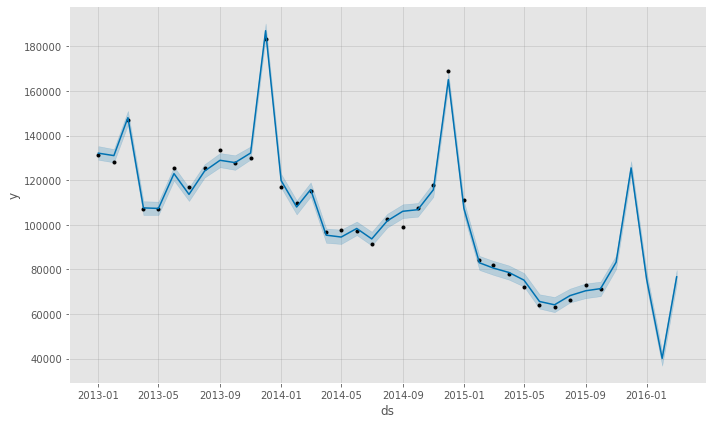

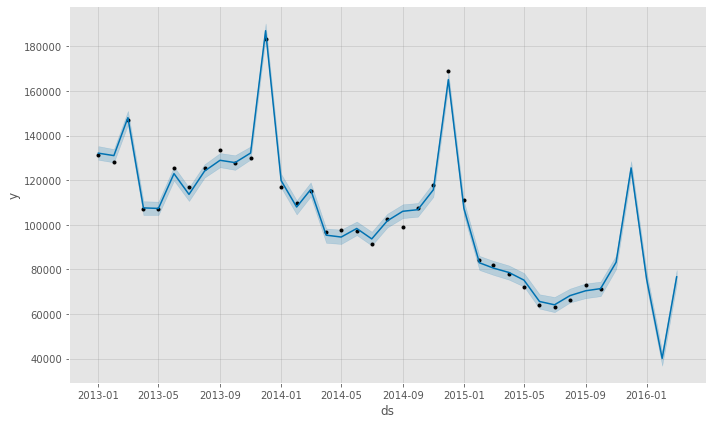

In [52]:
model.plot(forecast)

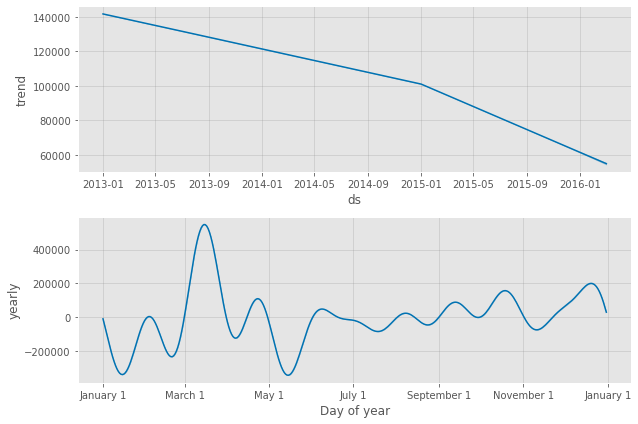

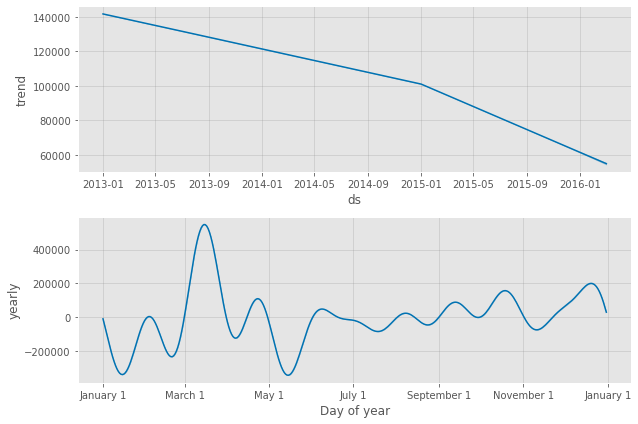

In [53]:
model.plot_components(forecast)

# Hierarchical time series

The Forecasting: principles and practice , is the ultimate reference book for forecasting by Rob J Hyndman.

He lays out the fundamentals of dealing with grouped or Hierarchical forecasts. Consider the following simple scenario.



Hyndman proposes the following methods to estimate the points in this hierarchy. I've tried to simplify the language to make it more intuitve.

Bottom up approach:

Predict all the base level series using any method, and then just aggregate it to the top.

Advantages: Simple , No information is lost due to aggregation.

Dis-advantages: Lower levels can be noisy

Top down approach:

Predict the top level first. (Eg: predict total sales first)

Then calculate weights that denote the proportion of the total sales that needs to be given to the base level forecast(Eg:) the contribution of the item's sales to the total 
sales

There are different ways of arriving at the "weights".

Average Historical Proportions - Simple average of the item's contribution to sales in the past months

Proportion of historical averages - Weight is the ratio of average value of bottom series by the average value of total series (Eg: Weight(item1)=

mean(item1)/mean(total_sales))

Forecasted Proportions - Predict the proportion in the future using changes in the past proportions

Use these weights to calcuate the base -forecasts and other levels

Middle out:

Use both bottom up and top down together.

Eg: Consider our problem of predicting store-item level forecasts.

Take the middle level(Stores) and find forecasts for the stores

Use bottoms up approach to find overall sales

Dis-integrate store sales using proportions to find the item-level sales using a top-down approach

Optimal combination approach:

Predict for all the layers independently

Since, all the layers are independent, they might not be consistent with hierarchy

Eg: Since the items are forecasted independently, the sum of the items sold in the store might not be equal to the forecasted sale of store or as Hyndman puts it “aggregate

consistent”

Then some matrix calculations and adjustments happen to provide ad-hoc adjustments to the forecast to make them consistent with the hierarchy

Enough with the theory. Lets start making forecasts! :P

The problem at hand here, has 22170 items and 60 stores . This indicates that there can be around a million individual time-series(item-store combinations) that we need to 

predict!

Configuring each of them would be nearly impossible. Let's use Prophet which does it for us.

Starting off with the bottoms up approach.

There are some other points to consider here:

Not all stores sell all items

What happens when a new product is introduced?

What if a product is removed off the shelves?

In [54]:
total_sales=sales.groupby(['date_block_num'])["item_cnt_day"].sum()
dates=pd.date_range(start = '2013-01-01',end='2015-10-01', freq = 'MS')

total_sales.index=dates
total_sales.head()

2013-01-01    131479.0
2013-02-01    128090.0
2013-03-01    147142.0
2013-04-01    107190.0
2013-05-01    106970.0
Freq: MS, Name: item_cnt_day, dtype: float64

In [55]:
# get the unique combinations of item-store from the sales data at monthly level
monthly_sales=sales.groupby(["shop_id","item_id","date_block_num"])["item_cnt_day"].sum()
# arrange it conviniently to perform the hts 
monthly_sales=monthly_sales.unstack(level=-1).fillna(0)
monthly_sales=monthly_sales.T
dates=pd.date_range(start = '2013-01-01',end='2015-10-01', freq = 'MS')
monthly_sales.index=dates
monthly_sales=monthly_sales.reset_index()
monthly_sales.head()

shop_id      index     0                                             ...  \
item_id               30    31    32   33    35   36   40   42   43  ...   
0       2013-01-01   0.0   0.0   6.0  3.0   1.0  0.0  0.0  0.0  1.0  ...   
1       2013-02-01  31.0  11.0  10.0  3.0  14.0  1.0  1.0  1.0  0.0  ...   
2       2013-03-01   0.0   0.0   0.0  0.0   0.0  0.0  0.0  0.0  0.0  ...   
3       2013-04-01   0.0   0.0   0.0  0.0   0.0  0.0  0.0  0.0  0.0  ...   
4       2013-05-01   0.0   0.0   0.0  0.0   0.0  0.0  0.0  0.0  0.0  ...   

shop_id    59                                                        
item_id 22144 22145 22150 22151 22153 22154 22155 22162 22164 22167  
0         0.0   0.0   0.0   2.0   0.0   1.0   0.0   0.0   0.0   0.0  
1         0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
2         0.0   0.0   0.0   1.0   0.0   0.0   0.0   0.0   0.0   0.0  
3         0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
4         0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  

[5 rows x 424125 columns]

In [ ]:
'''import time
start_time=time.time()

# Bottoms up
# Calculating the base forecasts using prophet
# From HTSprophet pachage -- https://github.com/CollinRooney12/htsprophet/blob/master/htsprophet/hts.py
forecastsDict = {}
for node in range(len(monthly_sales)):
    # take the date-column and the col to be forecasted
    nodeToForecast = pd.concat([monthly_sales.iloc[:,0], monthly_sales.iloc[:, node+1]], axis = 1)
#     print(nodeToForecast.head())  # just to check
# rename for prophet compatability
    nodeToForecast = nodeToForecast.rename(columns = {nodeToForecast.columns[0] : 'ds'})
    nodeToForecast = nodeToForecast.rename(columns = {nodeToForecast.columns[1] : 'y'})
    growth = 'linear'
    m = Prophet(growth, yearly_seasonality=True)
    m.fit(nodeToForecast)
    future = m.make_future_dataframe(periods = 1, freq = 'MS')
    forecastsDict[node] = m.predict(future)
    if (node== 10):
        end_time=time.time()
        print("forecasting for ",node,"th node and took",end_time-start_time,"s")
        break'''

# Middle out

In [57]:
monthly_shop_sales=sales.groupby(["date_block_num","shop_id"])["item_cnt_day"].sum()
# get the shops to the columns
monthly_shop_sales=monthly_shop_sales.unstack(level=1)
monthly_shop_sales=monthly_shop_sales.fillna(0)
monthly_shop_sales.index=dates
monthly_shop_sales=monthly_shop_sales.reset_index()
monthly_shop_sales.head()

shop_id,index,0,1,2,3,4,5,6,7,8,...,50,51,52,53,54,55,56,57,58,59
0,2013-01-01,5578.0,2947.0,1146.0,767.0,2114.0,0.0,3686.0,2495.0,1463.0,...,3406.0,2748.0,1812.0,2055.0,9386.0,0.0,3238.0,0.0,0.0,2017.0
1,2013-02-01,6127.0,3364.0,488.0,798.0,2025.0,877.0,4007.0,2513.0,1156.0,...,3054.0,2284.0,1737.0,1906.0,8075.0,0.0,2655.0,0.0,0.0,1897.0
2,2013-03-01,0.0,0.0,753.0,959.0,2060.0,1355.0,4519.0,2460.0,977.0,...,3610.0,2605.0,2034.0,2365.0,9488.0,0.0,3099.0,6586.0,3773.0,2028.0
3,2013-04-01,0.0,0.0,583.0,647.0,285.0,1008.0,3168.0,1540.0,-1.0,...,2740.0,1945.0,1446.0,1515.0,6726.0,0.0,2153.0,5493.0,2831.0,1388.0
4,2013-05-01,0.0,0.0,553.0,710.0,1211.0,1110.0,3022.0,1647.0,0.0,...,2839.0,2243.0,1482.0,1767.0,7006.0,852.0,2140.0,5233.0,2308.0,1374.0


In [58]:
start_time=time.time()

# Calculating the base forecasts using prophet
# From HTSprophet pachage -- https://github.com/CollinRooney12/htsprophet/blob/master/htsprophet/hts.py
forecastsDict = {}
for node in range(len(monthly_shop_sales)):
    # take the date-column and the col to be forecasted
    nodeToForecast = pd.concat([monthly_shop_sales.iloc[:,0], monthly_shop_sales.iloc[:, node+1]], axis = 1)
#     print(nodeToForecast.head())  # just to check
# rename for prophet compatability
    nodeToForecast = nodeToForecast.rename(columns = {nodeToForecast.columns[0] : 'ds'})
    nodeToForecast = nodeToForecast.rename(columns = {nodeToForecast.columns[1] : 'y'})
    growth = 'linear'
    m = Prophet(growth, yearly_seasonality=True)
    m.fit(nodeToForecast)
    future = m.make_future_dataframe(periods = 1, freq = 'MS')
    forecastsDict[node] = m.predict(future)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

In [59]:
#predictions = np.zeros([len(forecastsDict[0].yhat),1]) 
nCols = len(list(forecastsDict.keys()))+1
for key in range(0, nCols-1):
    f1 = np.array(forecastsDict[key].yhat)
    f2 = f1[:, np.newaxis]
    if key==0:
        predictions=f2.copy()
       # print(predictions.shape)
    else:
        predictions = np.concatenate((predictions, f2), axis = 1)

In [60]:
predictions_unknown=predictions[-1]
predictions_unknown

array([  240.8139322 ,   116.28589263,  1107.78516741,   888.86026936,
        1465.17303395,  1311.88427114,  2553.96936722,  1874.98194834,
        -103.61300882,   581.58036269,   706.7584699 ,    29.36442879,
        3684.86252821,  -533.0132714 ,  1125.91098769,  2102.61614636,
        1235.63309934,  1620.53162096,  1507.99916019,  1901.9932538 ,
        -681.46089582,  2090.00319908,  1744.75618697,  -742.48402521,
        2329.36463879,  6642.37729182,  1533.45948487,  6841.03564261,
        4470.311061  ,   145.57284416,   296.75211403,  8209.01206929,
       -1266.81428412,   775.57253956])